# Exercise 1:
In this exercise you should implement everything including the tests (e.g. the chi-square and KS tests) yourself. Later, when your code is working you are free to use builtin functions.

## 1. 
Write a program implementing a linear congruential generator (LCG). Be sure that the program works correctly using only integer representation.


In [207]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, chisquare


def LCG(n, a, c, M, seed):
    # Initialize the array to hold the generated numbers
    X = np.zeros(n)
    # Set the initial seed
    X[0] = seed
    # Generate the sequence
    for i in range(1, n):
        X[i] = (a * X[i-1] + c) % M
    return X

(a) Generate 10.000 (pseudo-) random numbers and present these numbers in a histogramme (e.g. 10 classes).

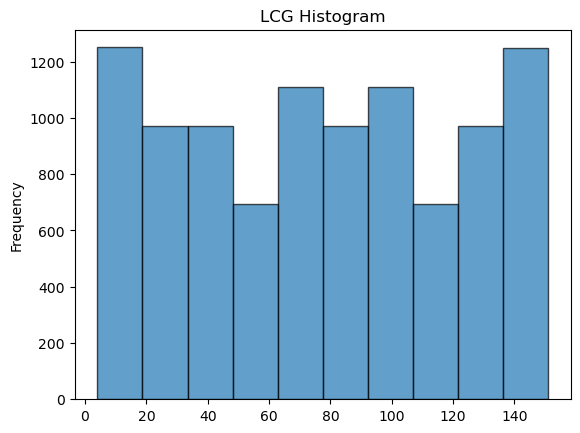

In [209]:
# Parameters
n = 10_000
a = 25
c = 1
M = 152
seed = 42

# Generate random numbers
rnd = LCG(n, a, c, M, seed)

plt.hist(rnd, bins=10, alpha=0.7, edgecolor='black')
plt.ylabel('Frequency')
plt.title('LCG Histogram')
plt.show()

(b) Evaluate the quality of the generator by graphical descriptive statistics (histogrammes, scatter plots) and
statistical tests - $\chi^2$, Kolmogorov-Smirnov, run-tests, and correlation test.

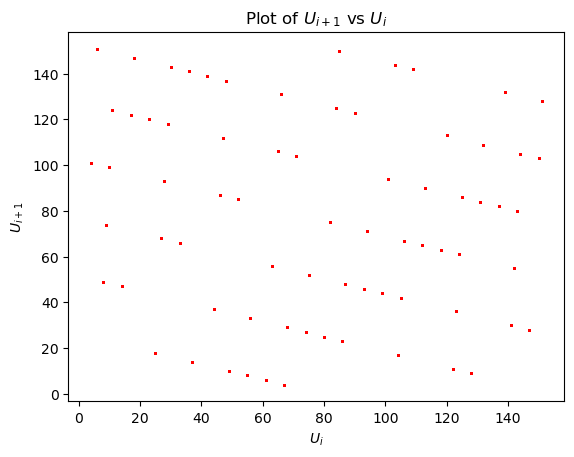

In [211]:
# Scatter plot  of U_i+1 versus U_i
plt.scatter(rnd[:-1], rnd[1:], marker='o', c='red', s=1)
plt.xlabel('$U_{i}$')
plt.ylabel('$U_{i+1}$')
plt.title('Plot of $U_{i+1}$ vs $U_{i}$')
plt.show()

In [213]:
# Chi-squared test

def chi_squared_test(rnd, classes):
    n = len(rnd)  # Total number of observations
    observed, _ = np.histogram(rnd, bins=classes)
    expected = np.full(classes, n / classes)
    chi_squared_stat = np.sum((observed - expected)**2 / expected)
    df = classes - 1  # Degrees of freedom
    p_value = 1 - chi2.cdf(chi_squared_stat, df)
    return chi_squared_stat, p_value

classes = 10
chi_squared_stat, p_value = chi_squared_test(rnd, classes)

print(f"Chi-squared test:")
print(f"Test Statistic: {chi_squared_stat}")
print(f"P-value: {p_value}")

Chi-squared test:
Test Statistic: 339.11199999999997
P-value: 0.0


In [217]:
# Kolmogorov-Smirnov test

def kolmogorov_smirnov_test(rnd):
    n = len(rnd)
    exp_cdf = np.sort(rnd) 
    ecdf = np.arange(1, n+1) / n
    
    D = np.max(np.abs(ecdf - exp_cdf))
    D_adjusted = (np.sqrt(n) + 0.12 + 0.11/np.sqrt(n)) * D
    
    # Calculating the p-value using the Kolmogorov distribution approximation
    p_value = 1 - norm.cdf(D_adjusted)

    return D_adjusted, p_value

D_adjusted, p_value = kolmogorov_smirnov_test(rnd)

print(f"Kolmogorov-Smirnov test:")
print(f"Test Statistic: {D_adjusted}")
print(f"Critical Value for the Adjusted D statistic: {1.358}")
print(f"P-value: {p_value}")

Kolmogorov-Smirnov test:
Test Statistic: 15019.54667118
Critical Value for the Adjusted D statistic: 1.358
P-value: 0.0


In [219]:
# Run test I

from scipy.stats import norm

def above_below(rnd):
    median = np.median(rnd)
    n1 = np.sum(rnd > median) # above median
    n2 = np.sum(rnd <= median) # below median
    Ra = 0
    Rb = 0

    for i in range(len(rnd) - 1):
        if rnd[i] > median and rnd[i + 1] < median: # Run above ends
            Ra += 1
        elif rnd[i] < median and rnd[i + 1] > median: # Run below ends
            Rb += 1

    T = Ra + Rb
    mu = 2 * (n1 * n2)/(n1 + n2) + 1
    sigma_2 = 2 * (n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2 - 1) * (n1 + n2)**2)

    # Test statistic and p-value calculations
    Z = (T - mu) / np.sqrt(sigma_2)
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    return Z, p_value

Z, p_value = above_below(rnd)

print(f"Run Test I:")
print(f"Z-Score: {Z}")
print(f"P-Value: {p_value}")

Run Test I:
Z-Score: 2.8001564733743587
P-Value: 0.005107784088592693


In [221]:
# Run Test II
from scipy.stats import chi2

def up_down(rnd):
    run_length = 1
    run_lengths = []
    for i in range(len(rnd) - 1):
        if rnd[i] < rnd[i + 1]:
            run_length += 1
        else:
            run_lengths.append(run_length)
            run_length = 1 # reset run_length

    run_lengths.append(run_length)

    # Calculate the number of runs of each length (1 to 6)
    n_runs = []
    for i in range(1, 7):
        n_run = np.sum(np.array(run_lengths) == i)
        n_runs.append(n_run)

    R = np.array(n_runs)
    A = np.array([[4529.4, 9044.9, 13568, 18091, 22615, 27892],
                  [9044.9, 18097, 27139, 36187, 45234, 55789],
                  [13568, 27139, 40721, 54281, 67852, 83685],
                  [18091, 36187, 54281, 72414, 90470, 111580],
                  [22615, 45234, 67852, 90470, 113262, 139476],
                  [27892, 55789, 83685, 111580, 139476, 172860]])
    B = np.array([1/6, 5/24, 11/120, 19/720, 29/5040, 1/840])

    # Finally calculate the Z statistic and p-value
    n = len(rnd)
    diff = R - n * B
    Z = (1 / (n - 6)) * diff.T @ A @ diff
    p_value = 1 - chi2.cdf(Z, df=6)
    return Z, p_value

Z, p_value = up_down(rnd)

print(f"Run Test II:")
print(f"Z: {Z}")
print(f"P-Value: {p_value}")

Run Test II:
Z: 1480.427713821547
P-Value: 0.0


In [223]:
# Run Test III

def up_and_down(rnd):
    up_n_down = []
    n = len(rnd)
    for i in range(n - 1):
        if rnd[i] < rnd[i + 1]:
            up_n_down.append('<')
        else:
            up_n_down.append('>')

    X = 0

    for i in range(len(up_n_down) - 1):
        if up_n_down[i] != up_n_down[i + 1]:
            X += 1
            
    Z = (X - (2 * n - 1) / 3) / np.sqrt((16 * n - 29) / 90)
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    return Z, p_value

Z, p_value = up_and_down(rnd)

print(f"Run Test III:")
print(f"Z: {Z}")
print(f"P-Value: {p_value}")

Run Test III:
Z: 13.179986639168702
P-Value: 0.0


In [235]:
# Correlation Test

def correlation_test(rnd, h):
    n = len(rnd)
    ch = 0
    for i in range(n - h):
        ch += rnd[i] * rnd[i + h]
        
    ch /= n - h
    Z = (ch - 0.25) / np.sqrt(7 / (144 * n))
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    return ch, Z, p_value

# lag h
h = 2
ch, Z, p_value = correlation_test(rnd, h)

print(f"Correlation Test:")
print(f"c_h: {ch}")
print(f"Z: {Z}")
print(f"P-Value: {p_value}")

Correlation Test:
c_h: 6174.008101620324
Z: 2800153.4728384474
P-Value: 0.0


(c)  Repeat (a) and (b) by experimenting with different values of “a”, “b” and “M”. In the end you should have a decent generator. Report at least one bad and your final choice.

**Solution:**

The one above with $a = 25$, $c = 1$ and $M = 152$ is very bad. We tried different values and found this one which is okay good: $a = 7^2$, $c = 0$ and $M = 2^{32}-1$. Plots and tests can be seen below.

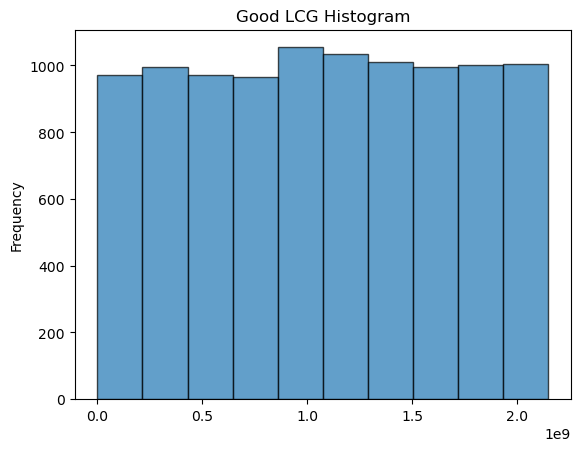

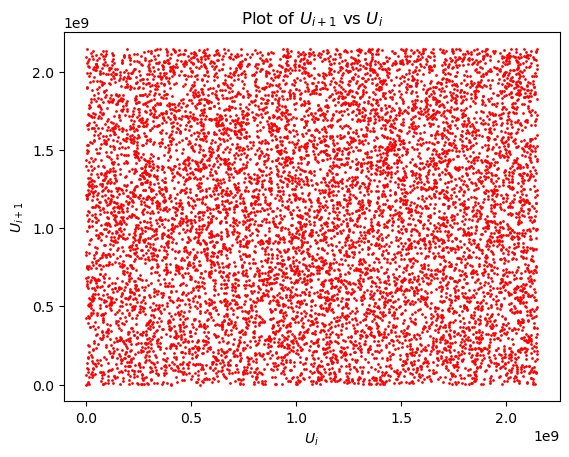

Chi-squared test:
Test Statistic: 7.2940000000000005
P-value: 0.6065390192120514

Kolmogorov-Smirnov test:
Test Statistic: 215008390027.3878
Critical Value for the Adjusted D statistic: 1.358
P-value: 0.0

Run Test I:
Z-Score: -0.2600130022754063
P-Value: 0.7948537440906605

Run Test II:
Z: 3.059508771526213
P-Value: 0.8013416572675307

Run Test III:
Z: -0.3162564280544306
P-Value: 0.7518078804813186

Correlation Test:
c_h: 1.1656874665591265e+18
Z: 5.287061387897777e+20
P-Value: 0.0


In [237]:
# Good generator
a = 7**5
c = 0
M = 2**31 - 1
seed = 3

# Generate random numbers
good_rnd = LCG(n, a, c, M, seed)

plt.hist(good_rnd, bins=10, alpha=0.7, edgecolor='black')
plt.ylabel('Frequency')
plt.title('Good LCG Histogram')
plt.show()

# Scatter plot  of U_i+1 versus U_i
plt.scatter(good_rnd[:-1], good_rnd[1:], marker='o', c='red', s=1)
plt.xlabel('$U_{i}$')
plt.ylabel('$U_{i+1}$')
plt.title('Plot of $U_{i+1}$ vs $U_{i}$')
plt.show()

# Chi-squared test
chi_squared_stat, p_value = chi_squared_test(good_rnd, classes)

print(f"Chi-squared test:")
print(f"Test Statistic: {chi_squared_stat}")
print(f"P-value: {p_value}\n")

# KS test
D_adjusted, p_value = kolmogorov_smirnov_test(good_rnd)

print(f"Kolmogorov-Smirnov test:")
print(f"Test Statistic: {D_adjusted}")
print(f"Critical Value for the Adjusted D statistic: {1.358}")
print(f"P-value: {p_value}\n")

# Run Test I
Z, p_value = above_below(good_rnd)

print(f"Run Test I:")
print(f"Z-Score: {Z}")
print(f"P-Value: {p_value}\n")

# Run Test II
Z, p_value = up_down(good_rnd)

print(f"Run Test II:")
print(f"Z: {Z}")
print(f"P-Value: {p_value}\n")

# Run Test III
Z, p_value = up_and_down(good_rnd)

print(f"Run Test III:")
print(f"Z: {Z}")
print(f"P-Value: {p_value}\n")

# Correlation Test
h = 2
ch, Z, p_value = correlation_test(good_rnd, h)

print(f"Correlation Test:")
print(f"c_h: {ch}")
print(f"Z: {Z}")
print(f"P-Value: {p_value}")

## 2.
Apply a system available generator and perform the various statistical tests you did under Part 1 point (b) for this
generator too.

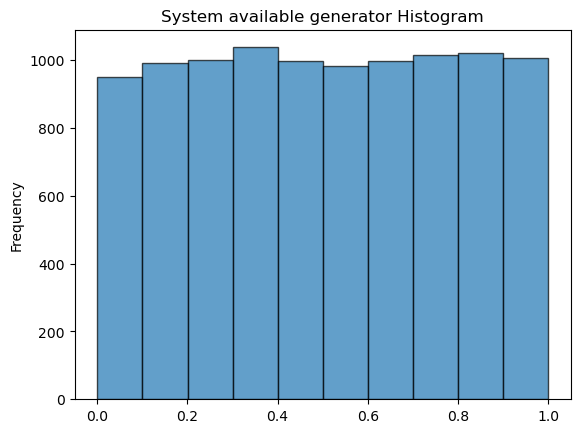

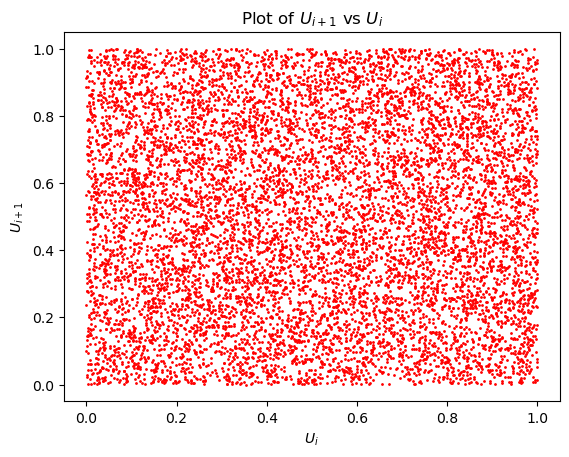

Chi-squared test:
Test Statistic: 5.088000000000001
P-value: 0.8265705667610133

Kolmogorov-Smirnov test:
Test Statistic: 0.8294555977695741
Critical Value for the Adjusted D statistic: 1.358
P-value: 0.2034233261023034

Run Test I:
Z-Score: -0.10000500087515626
P-Value: 0.9203403552266689

Run Test II:
Z: 11.7653913486933
P-Value: 0.06741201162959498

Run Test III:
Z: -0.15022180332585075
P-Value: 0.8805896245168312

Correlation Test:
c_h: 0.2541183930826707
Z: 1.8679275253637742
P-Value: 0.06177217361129261


In [241]:
# System available generator

best_rnd = np.random.rand(n)

plt.hist(best_rnd, bins=10, alpha=0.7, edgecolor='black')
plt.ylabel('Frequency')
plt.title('System available generator Histogram')
plt.show()

# Scatter plot  of U_i+1 versus U_i
plt.scatter(best_rnd[:-1], best_rnd[1:], marker='o', c='red', s=1)
plt.xlabel('$U_{i}$')
plt.ylabel('$U_{i+1}$')
plt.title('Plot of $U_{i+1}$ vs $U_{i}$')
plt.show()

# Chi-squared test
chi_squared_stat, p_value = chi_squared_test(best_rnd, classes)

print(f"Chi-squared test:")
print(f"Test Statistic: {chi_squared_stat}")
print(f"P-value: {p_value}\n")

# KS test
D_adjusted, p_value = kolmogorov_smirnov_test(best_rnd)

print(f"Kolmogorov-Smirnov test:")
print(f"Test Statistic: {D_adjusted}")
print(f"Critical Value for the Adjusted D statistic: {1.358}")
print(f"P-value: {p_value}\n")

# Run Test I
Z, p_value = above_below(best_rnd)

print(f"Run Test I:")
print(f"Z-Score: {Z}")
print(f"P-Value: {p_value}\n")

# Run Test II
Z, p_value = up_down(best_rnd)

print(f"Run Test II:")
print(f"Z: {Z}")
print(f"P-Value: {p_value}\n")

# Run Test III
Z, p_value = up_and_down(best_rnd)

print(f"Run Test III:")
print(f"Z: {Z}")
print(f"P-Value: {p_value}\n")

# Correlation Test
h = 2
ch, Z, p_value = correlation_test(best_rnd, h)

print(f"Correlation Test:")
print(f"c_h: {ch}")
print(f"Z: {Z}")
print(f"P-Value: {p_value}")

## 3.
You were asked to simulate one sample and perform tests on this sample. Discuss the sufficiency of this approach and take
action, if needed.

**Solution:**

